In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

In [2]:
# Construct a camera calibration function
def cal_camera(cal_images_path, parameters_save_path):
    
    # Read in and make a list of calibration images
    images = glob.glob(cal_images_path)

    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0),...,(7,5,0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # x, y coordinates
    draw_index = 1
    fig = plt.figure(1, figsize=(16, 9))
    for fname in images:
        img = mpimg.imread(fname)
    
        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    # Calculate camera matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Save the calibration parameters
    camera_paras = {}
    camera_paras["mtx"] = mtx
    camera_paras["dist"] = dist
    pickle.dump(camera_paras, open(parameters_save_path,"wb"))

In [3]:
# Construct a function to undistort image
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

In [27]:
def binary_transfor(img, l_thresh=(215, 255), b_thresh=(145, 200)):
    # Convert to HLS color space and separate the L channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #s_channel = hls[:,:,2]
    
    #s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= 180) & (s_channel <= 255)] = 1
    
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= 220) & (r_channel <= 255)] = 1

    # Convert to HLS color space and separate the L channel
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV).astype(np.float)
    l_channel = luv[:,:,0]
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    #r_channel = img[:,:,0]
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    b_channel = lab[:,:,2]
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(b_binary), sxbinary, s_binary)) * 255  
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(l_channel)
    # good 1 combined_binary[(l_binary == 1) | (b_binary == 1) ] = 1
    combined_binary[(l_binary == 1) | (b_binary == 1) ] = 1
    stacked_binary = np.dstack((combined_binary, combined_binary, combined_binary)) * 255
    return combined_binary, stacked_binary

In [5]:
# Construct a function to make perspective transform so that hte lines look
# straight from a bird's eye view, it returns perspective transform matrixs
def get_M(img):
    img_size = (img.shape[1], img.shape[0])
    # Four source coordinates
    src = np.float32([[733, 477], [1110, 719], [226, 719],[559, 477]])
    # Four desired coordinates
    dst = np.float32([[1010, 350], [1010, 719], [336, 719],[336, 350]])
    
    # Compute the perspective transform matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse erspective transform matrix Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv


In [6]:
def warp(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_image

In [7]:
# Define function to find the lane boundary
def line_fit(binary_warped, nwindows=9, margin=100, minpix=50):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    img_with_window = np.dstack((binary_warped, binary_warped, binary_warped))*255
    img_without_window = np.copy(img_with_window)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = nwindows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = margin
    # Set minimum number of pixels found to recenter window
    minpix = minpix
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(img_with_window,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(img_with_window,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    #img_with_window[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #img_with_window[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    img_without_window[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    img_without_window[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return img_without_window, leftx, lefty, rightx, righty

In [8]:
# Define function to calculate the curvature of the lane and vehicle position with respect to center
def cal_radius_and_caroff(binary_img_size, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix):
   
    # Fit a second order polynomial to pixel positions in each lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define y-value where we can get the x coordinate of the bottom of lane lines
    y_eval_position = binary_img_size[0] - 1
    
    base_left = left_fit[0]*y_eval_position**2 + left_fit[1]*y_eval_position + left_fit[2]
    base_right = right_fit[0]*y_eval_position**2 + right_fit[1]*y_eval_position + right_fit[2]
    car_position = binary_img_size[1] // 2
    lane_center = base_left + (base_right - base_left)/2
    car_offset = (car_position - lane_center)*xm_per_pix
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval_radius = (binary_img_size[0]-1)*ym_per_pix
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_radius + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_radius + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return car_offset, left_curverad, right_curverad

In [9]:
def project_lines(undist2warp, leftx, lefty, rightx, righty, Minv, left_rad, right_rad, car_off):
    ploty = np.linspace(0, undist2warp.shape[0]-1, undist2warp.shape[0])
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist2warp.shape[1], undist2warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist2warp, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left radius: ' + str(round(left_rad, 1)) + 'm', (50,50), cv2.FONT_HERSHEY_COMPLEX,
                1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(result, 'Right radius: ' + str(round(right_rad, 1)) + 'm', (50,80), cv2.FONT_HERSHEY_COMPLEX,
                1, (255,0,0), 2, cv2.LINE_AA)
    cv2.putText(result, 'Car is ' + str(round(car_off, 3)) + 'm right of center', (50, 110), cv2.FONT_HERSHEY_COMPLEX,
                1, (255,0,0), 2, cv2.LINE_AA)
    
    return result

In [10]:
def add_picture_windows(ground_picture, window_picture1, window_picture2):
    result = np.copy(ground_picture)
    
    add_picture_1 = cv2.resize(window_picture1, (400,240), interpolation=cv2.INTER_AREA)
    add_picture_2 = cv2.resize(window_picture2, (400,240), interpolation=cv2.INTER_AREA)
    
    result[120:360,100:500,:] = add_picture_1
    result[120:360,750:1150,:] = add_picture_2
    #fig = plt.figure(1, figsize=(16,9))
    #ax = fig.add_subplot(1,1,1)
    #plt.imshow(result)
    return result

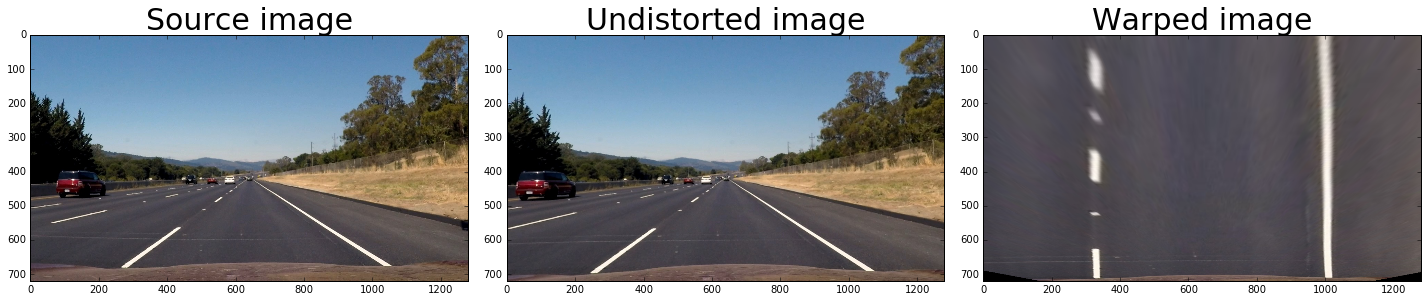

In [11]:
dist_pickle = pickle.load( open("camera_parameters.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

M_image2undist = mpimg.imread('test_images/straight_lines2.jpg')
origin_img_size = (M_image2undist.shape[0], M_image2undist.shape[1], M_image2undist.shape[2])
binary_img_size = (M_image2undist.shape[0], M_image2undist.shape[1])

# Undistort the image using function cal_undistort()
M_undist2warp = cal_undistort(M_image2undist, mtx, dist)
# Calculate the perspective transform matrix using function get_M()
perspective_M, Minv = get_M(M_undist2warp)
# Make perspective transform using function warp()
M_warped_image = warp(M_undist2warp, perspective_M)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
f.tight_layout()
ax1.set_title('Source image', fontsize=30)
ax1.imshow(M_image2undist)
ax2.set_title('Undistorted image', fontsize=30)
ax2.imshow(M_undist2warp)
ax3.set_title('Warped image', fontsize=30)
ax3.imshow(M_warped_image)

In [12]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [13]:
image2undist = mpimg.imread('test_images/test5.jpg')
undist2warp = cal_undistort(image2undist, mtx, dist)
binary_undist, stacked_binary = binary_transfor(undist2warp)
binary_warped = warp(binary_undist, perspective_M)

In [14]:
img_without_window, leftx, lefty, rightx, righty = line_fit(binary_warped)

In [15]:
car_offset, left_radius, right_radius = cal_radius_and_caroff(binary_img_size, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)
print('car off center: ', car_offset, 'm')
print('left radius: ', left_radius, 'm')
print('right radius: ', right_radius, 'm')

car off center:  -0.120200159843 m
left radius:  716.85920407 m
right radius:  428.437953341 m


In [16]:
result_img = project_lines(undist2warp, leftx, lefty, rightx, righty, Minv, left_radius, right_radius, car_offset)

In [17]:
window_result_img = add_picture_windows(result_img, stacked_binary, img_without_window)

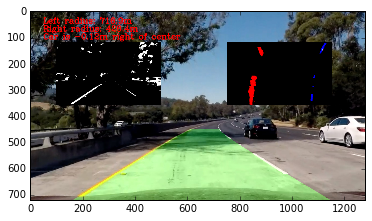

In [18]:
plt.imshow(window_result_img)

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:

#def process_image(image, mtx, dist, M, Minv, xm_per_pix, ym_per_pix):
    #image2undist = np.copy(image)
    #undist2warp = cal_undistort(image2undist, mtx, dist)
    #binary_undist, stacked_binary = binary_transfor(undist2warp)
    #binary_warped = warp(binary_undist, perspective_M)
    #img_without_window, leftx, lefty, rightx, righty = line_fit(binary_warped)
    #car_offset, left_radius, right_radius = \
    #cal_radius_and_caroff(binary_img_size, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)
    #result_img = project_lines(undist2warp, leftx, lefty, rightx, righty, Minv, left_radius, right_radius, car_offset)
    #window_result_img = add_picture_windows(result_img, stacked_binary, img_without_window)
    #return window_result_img


In [21]:
def process_image(image):
    image2undist = np.copy(image)
    undist2warp = cal_undistort(image2undist, mtx, dist)
    binary_undist, stacked_binary = binary_transfor(undist2warp)
    binary_warped = warp(binary_undist, perspective_M)
    img_without_window, leftx, lefty, rightx, righty = line_fit(binary_warped)
    car_offset, left_radius, right_radius = \
    cal_radius_and_caroff(binary_img_size, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)
    result_img = project_lines(undist2warp, leftx, lefty, rightx, righty, Minv, left_radius, right_radius, car_offset)
    window_result_img = add_picture_windows(result_img, stacked_binary, img_without_window)
    return window_result_img

In [25]:
white_output = 'output_videos/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4



 24%|██▍       | 303/1261 [00:52<02:49,  5.65it/s]


 48%|████▊     | 605/1261 [01:45<01:55,  5.70it/s]


 72%|███████▏  | 907/1261 [02:38<01:01,  5.76it/s]


 96%|█████████▌| 1205/1261 [03:30<00:09,  5.81it/s]


100%|█████████▉| 1260/1261 [03:40<00:00,  5.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 7min 41s, sys: 4.3 s, total: 7min 45s
Wall time: 3min 41s
